# Using beamforming to localize alpha power in the resting state

The aim of this section is to localize modulations of oscillatory power with resting-state Magnetoencephalography data. The will be done using the Linearly Constrained Minimum Variance (LCMV) approach (van Veen et al., 1997). This is a beamforming approach based on spatial filtering. For each grid point in the brain as spatial filter is derived based on the forward model and the covariance matrix. This allow for estamation the power modulations at each grid points which then is mapped onto the indiviual structural MRIs.


### Preparation

Import the relevant Python modules:

In [1]:
import os.path as op
import numpy as np
import mne
from mne.cov import compute_covariance
from mne.beamformer import make_lcmv, apply_lcmv_cov

Set the paths and name for the data. Note that these will depend on your local setup.

In [2]:
result_path = r'C:\MSc_Project\Data_Control\sub003_20220611_b47b'
file_name = 'rest_epoch.fif'
path_file  = op.join(result_path,file_name) 


### The forward model

For this example we will use a forward model already calculated. Please refer to the <a href="https://mne.tools/dev/auto_tutorials/forward/30_forward.html">MNE documentation</a> for how to calculate the forward model using FreeSurfer.

In [3]:
fwd_name = 'T1_anon_defaced-volume_fwd.fif'
fwd_fname = op.join(result_path,fwd_name) 
fwd = mne.read_forward_solution(fwd_fname)

Reading forward solution from C:\MSc_Project\Data_Control\sub003_20220611_b47b\T1_anon_defaced-volume_fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (12135 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


This is the forward model constructed for the 306 MEG sensors with respect to the brain surface of 8195 sources (grid points).

# Read the trials

Now read the epochs for all trial types combined. We here focus on the alpha band modulations; therefore bandpass filter the data at 8 to 12 Hz and select the gradiometer data only:

In [4]:
epochs = mne.read_epochs(path_file)
epochs = epochs.pick_types(meg='grad')
epochs = epochs.filter(8, 12).copy()

Reading C:\MSc_Project\Data_Control\sub003_20220611_b47b\rest_epoch.fif ...
    Found the data of interest:
        t =       0.00 ...    9999.00 ms
        0 CTF compensation matrices available


C:\Users\daizhongpengMNE\AppData\Local\Temp\ipykernel_31988\1202090984.py:1: RuntimeWarning: This filename (C:\MSc_Project\Data_Control\sub003_20220611_b47b\rest_epoch.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(path_file)


Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 1651 samples (1.651 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2652 out of 2652 | elapsed:    1.8s finished


### Calculating the covariance matrices 

The spatial filters in the LCMV beamforming approach are calculated using the forward model and the covariance matrices. The covarience matrices are calculated for each interval in order to later create a common spatial filter.

In [5]:
rank = mne.compute_rank(epochs, tol=1e-6, tol_kind='relative')
methods = ['shrunk', 'diagonal_fixed', 'empirical', 'factor_analysis']
common_cov = compute_covariance(epochs,method = methods[2] ,rank=rank,n_jobs = 4,verbose=True)


Computing rank from data with rank=None
    Estimated rank (grad): 69
    GRAD: rank 69 computed from 204 data channels with 0 projectors
Computing rank from data with rank={'grad': 69}
    Setting small GRAD eigenvalues to zero (without PCA)
Reducing data rank from 204 -> 69
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 130000
[done]


Lets now consider the rank for the coveriance matrix: 

Computing rank from covariance with rank=None
    Using tolerance 5.9e-14 (2.2e-16 eps * 204 dim * 1.3  max singular value)
    Estimated rank (grad): 69
    GRAD: rank 69 computed from 204 data channels with 0 projectors


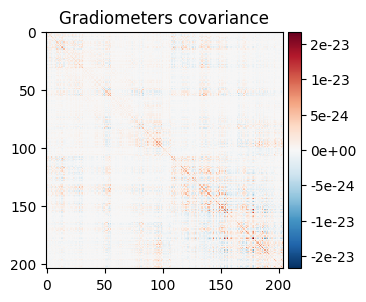

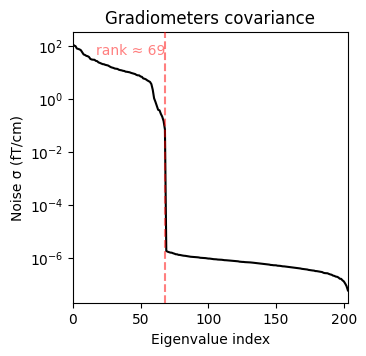

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [6]:
common_cov.plot(epochs.info)

Note that the rank is 69 eventhough there were 204 gradiometers used in the calculations. The rank deficiency is caused by the SSS algorithm and therefore requires a regulatization before inverting in the beamforming calculation. 

### Derive the spatial filters

Now calculate the filters using the forward model (*fwd*) and the combined covariance matrix (*common_cov*). The filters were regularized corresponding to loading the diagonal of the covariance matrix with 5% of the sensor power. For each source the orientation was optimized to maximize the power of the output.The rank of the denominator of the beamformer formula (i.e., during pseudo-inversion) will be reduced by one for each spatial location. All three dipoles at a source vertex are considered as a group and the spatial filters are computed jointly using a matrix inversion.

In [7]:
filters = make_lcmv(epochs.info, 
                            fwd, 
                            common_cov, 
                            reg=0.05,
                            noise_cov=None, 
                            rank = rank,
                            pick_ori='max-power',
                            reduce_rank = True,
                            depth = 0.8,
                            inversion = 'matrix',
                            weight_norm = 'nai'
                            ) 

Computing rank from covariance with rank={'grad': 69}
Computing rank from covariance with rank={'grad': 69}
Making LCMV beamformer with rank {'grad': 69}
Computing inverse operator with 204 channels.
    204 out of 306 channels remain after picking
Selected 204 channels
Creating the depth weighting matrix...
Whitening the forward solution.
Computing rank from covariance with rank={'grad': 69}
    Setting small GRAD eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 12135 sources
Filter computation complete


### Apply the spatial filters

Then apply the filter to the data:

In [8]:
stc = apply_lcmv_cov(common_cov,filters)

### Plotting the source results

Showing: t = 0.000 s, (58.1, -12.0, -24.2) mm, [27, 15, 16] vox, 19530 vertex
Using control points [ 6.57816629  7.11398695 11.12549841]


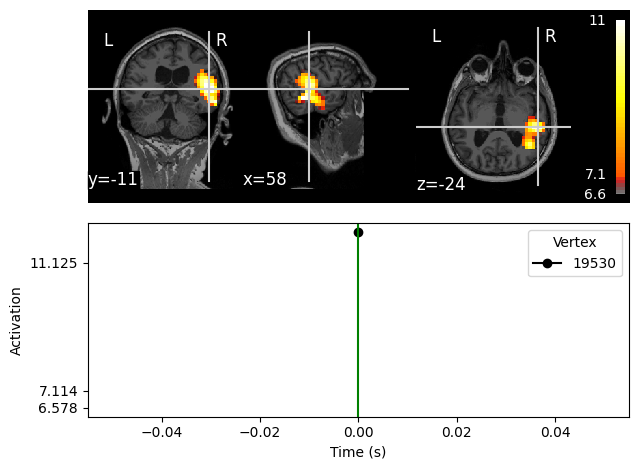

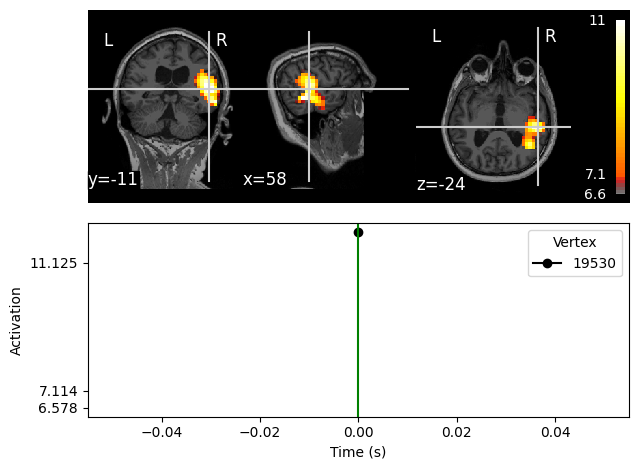

In [9]:
stc.plot(src=fwd['src'], subject='T1_anon_defaced', subjects_dir=r'C:\MSc_Project\Data_Control\sub001_20220609_b5e4', 
              mode='stat_map')

### References
Van Veen, B.D, van Drongelen, W., Yuchtman, M., and Suzuki, A. (1997). Localization of brain electrical activity via linearly constrained minimum variance spatial filtering. IEEE Transactions on Biomedical Engineering, 44(9):867–880.       